In [8]:
import tools
import pandas as pd
import sys, os
sys.path.append('./VisualFeatureSearch')
from vissearch import widgets, util, data
import numpy as np
import torch.nn as nn
import matplotlib
import matplotlib.pyplot as plt
import torch
from torchvision import transforms, utils

Random number generated: 12
Image path: ILSVRC2012_val_00000013.JPEG
Image label:370


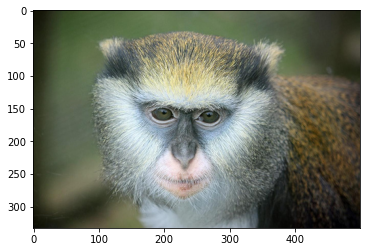

Image classification:  'guenon, guenon monkey'


In [27]:
image, label = tools.load_random_image()
lable_name = pd.read_csv('val_250/lables.txt', sep = ':')
class_names = []
for i in range(1000):
    class_names.append(lable_name.iloc[i-1, 1].rstrip(","))

print('Image classification: {}'.format(class_names[label]))

In [28]:
convert_tensor = transforms.ToTensor()

size = (224, 224)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

transform = transforms.Compose([
    transforms.Resize(size),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std) # (x - mean) / std
])

query_vis_transform = transforms.Compose([
    transforms.CenterCrop((256,256)),
    transforms.Resize((224,224))
])

query_model_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

query_img = query_vis_transform(image)
# convert images to Data URLs so we can pass them into the HTML widget
query_img_url = util.image_to_durl(query_img)

test = None

def highlight_callback(data):
    global test
    mask = util.durl_to_image(data)
    mask_arr = np.asarray(mask)[:,:,3] / 256 # take just the alpha channel

    curr_mask_overlay = util.mask_overlay(query_img, x=0, y=0, mask_size=224, mask=mask_arr, alpha=0.5, beta=0.4)

    model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=True)
    model.eval()
    
    img_input = tools.img_transform(query_img)
    mask_input = tools.mask_transform(mask_arr)
    data_out = tools.score_gen(tools.transform_Gaussian, img_input, mask_input, model)
    test = 0
    return data_out
    
util.create_callback('highlight_callback', highlight_callback)
widgets.HighlightWidget(query_img_url, callback_name='highlight_callback')